In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML

display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-10-18 19:27:56,996	INFO worker.py:1636 -- Started a local Ray instance.


In [2]:
import utils
utils

<module 'utils' from '/home/kianmilani/Projects/roman-cgi-iefc/utils.py'>

In [12]:
import iefc_2dm

In [9]:
import sys
sys.path.append('iefc-scripts')

In [10]:
import iefc_2dm_spc_wide_band4b_had_modes

ImportError: cannot import name 'conf' from 'poppy' (unknown location)

In [4]:
from .math_module import xp

ImportError: attempted relative import with no known parent package

0.1 0.0072010264910560605 arcsec / pix


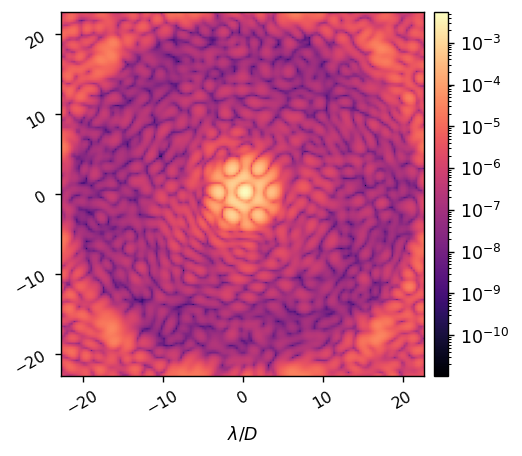

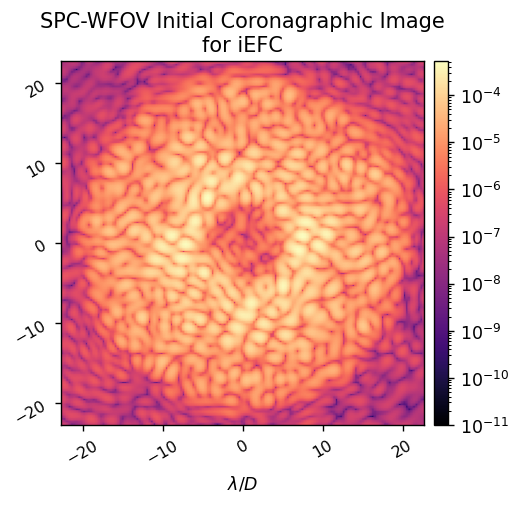

In [2]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

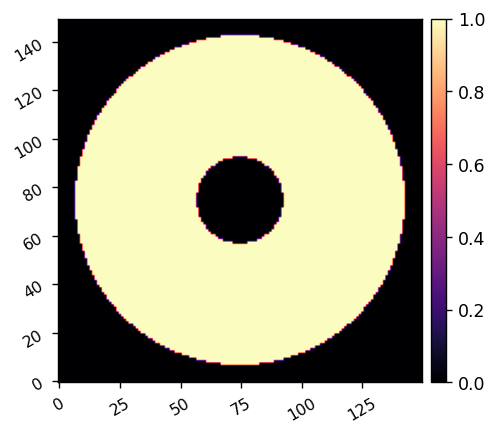

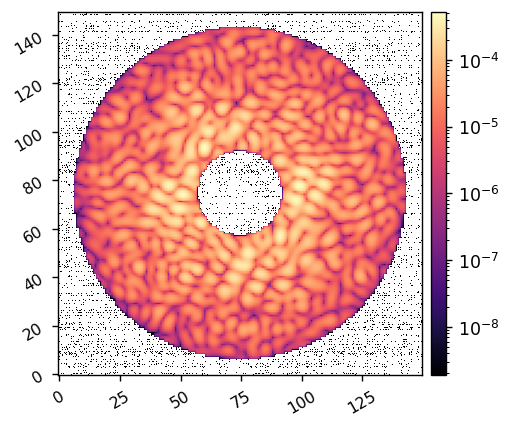

3.042688486608366e-05


In [3]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

imshow1(control_mask*ref_im, lognorm=True, save_fig='test_control_mask.png')
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

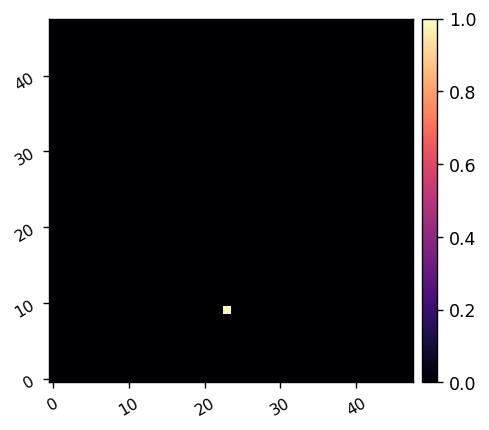

In [9]:
command = np.zeros((mode.Nact,mode.Nact))
command[9,23] = 1
imshow1(command)

In [16]:
amps = np.linspace(0, 75, 76)*1e-9

rms_vals = np.zeros(len(amps))
for i,amp in enumerate(amps):
    mode.set_dm1(amp*command)
    e1 = mode.calc_psf()
    mode.set_dm1(-amp*command)
    e2 = mode.calc_psf()

    # response = (e1-e2)/(2*amp)
    response = (e1-e2)/(2)
    rms_vals[i] = xp.sqrt(xp.mean(xp.abs(response[control_mask])**2))

In [17]:
slope = (rms_vals[1]-rms_vals[0])/(amps[1]-amps[0])

Text(0.5, 0, 'Amplitude of Actuator Poke [nm]')

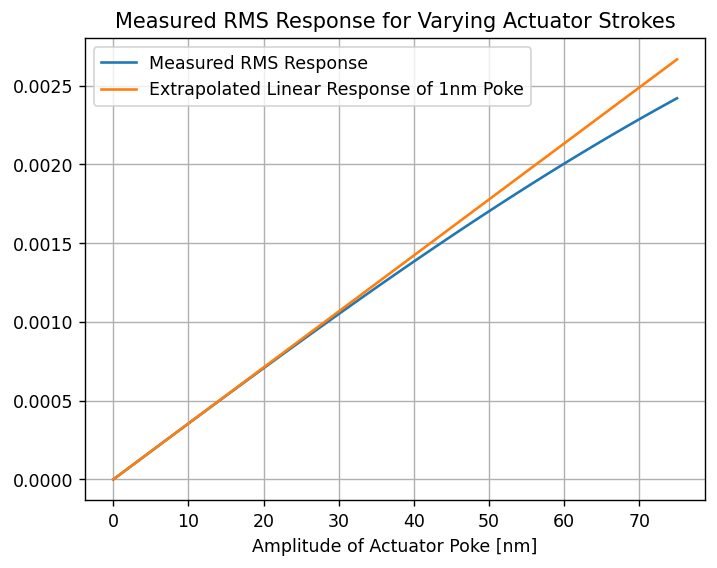

In [24]:
import matplotlib.pyplot as plt

plt.figure(dpi=125)
plt.plot(amps*1e9, rms_vals, label='Measured RMS Response')
plt.plot(amps*1e9, slope*amps, label='Extrapolated Linear Response of 1nm Poke')
plt.grid()
plt.legend()
plt.title('Measured RMS Response for Varying Actuator Strokes')
plt.xlabel('Amplitude of Actuator Poke [nm]')

2.5513179788999333e-09


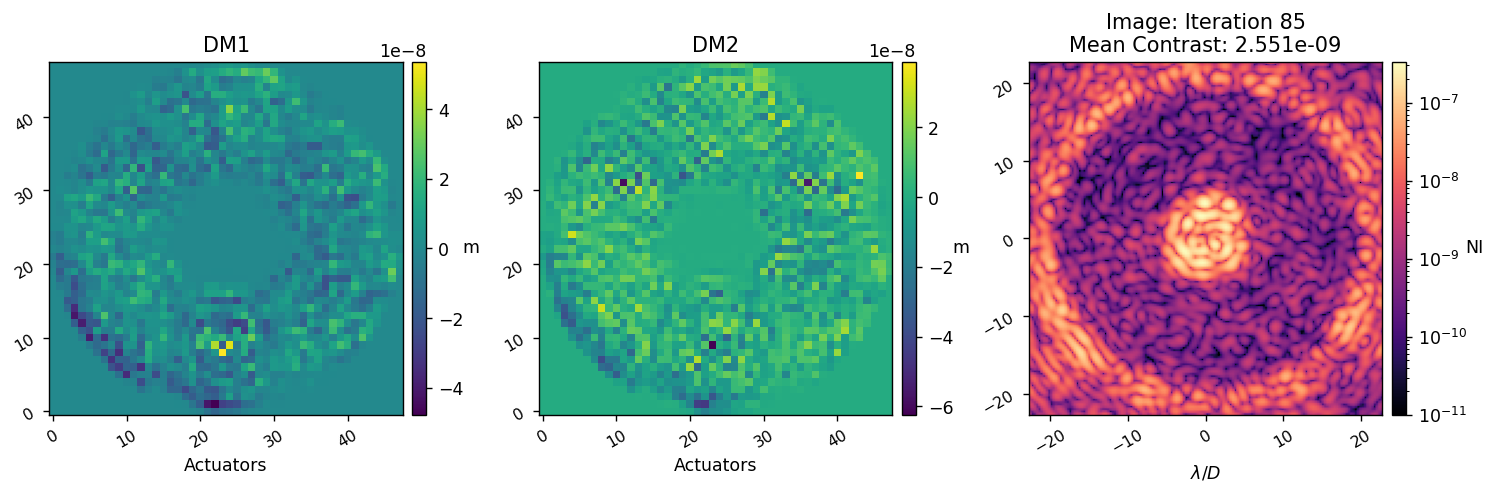

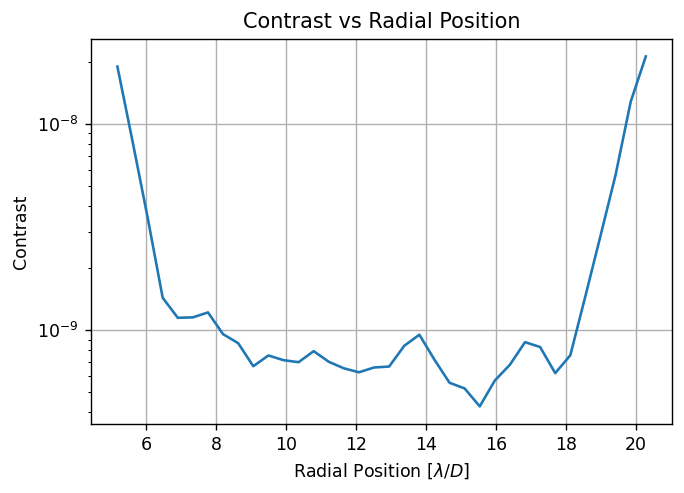

In [11]:
date = 20230921
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_images_{date}.fits')

poke_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(poke_contrast)
print(poke_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i}\nMean Contrast: {poke_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators', xlabel3='$\lambda/D$', 
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

2.956956233174829e-08


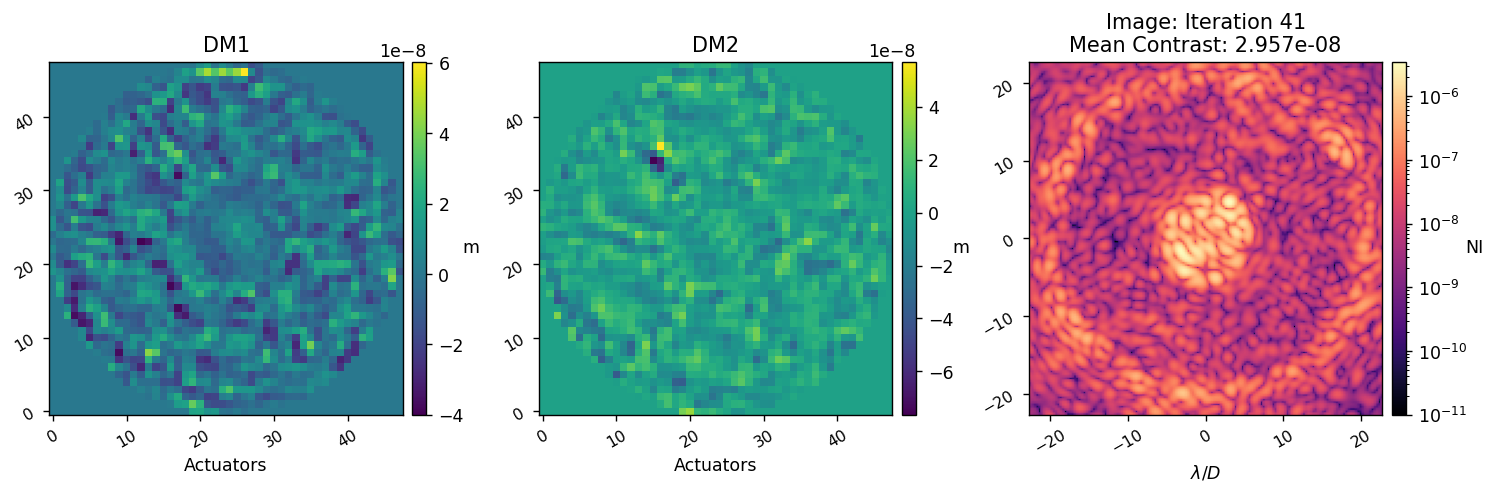

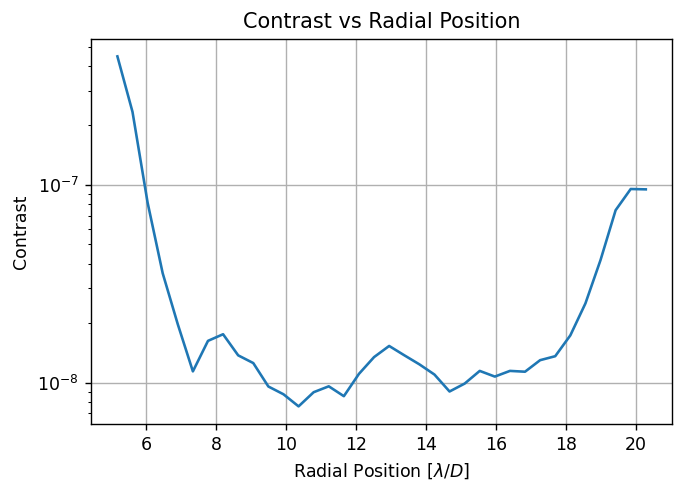

In [9]:
date = 20230926
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_images_{date}.fits')

fourier_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)
fourier_contrast.shape

i = np.argmin(fourier_contrast)

print(fourier_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i}\nMean Contrast: {fourier_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators', xlabel3='$\lambda/D$', 
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

2.141313223564066e-09


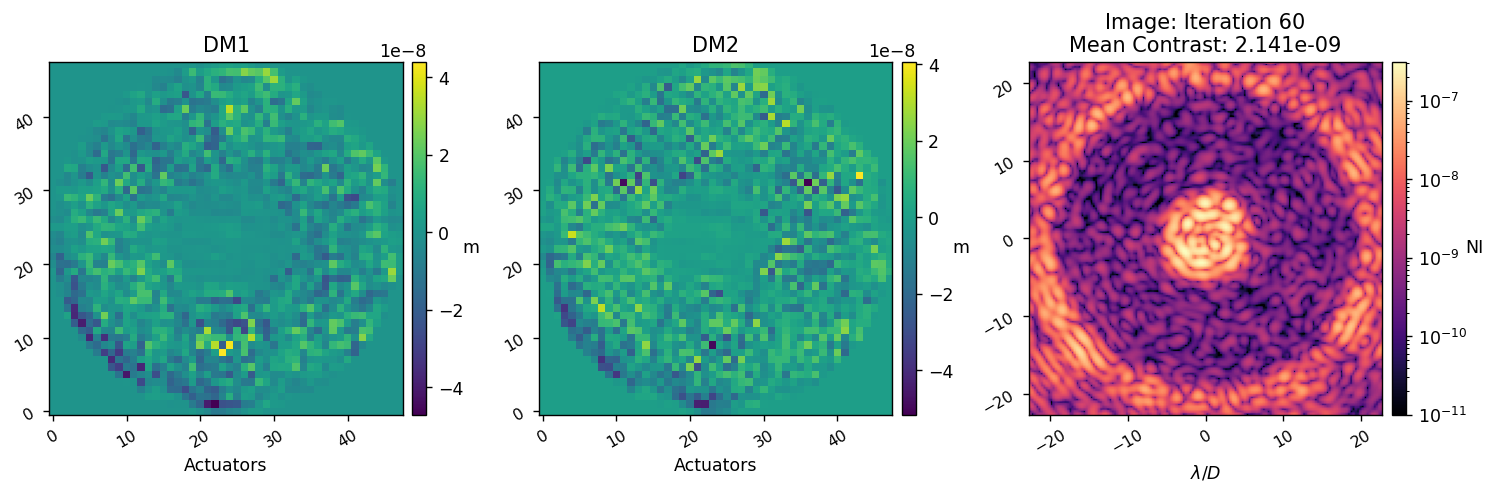

In [13]:
date = 20230925
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_had_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_had_images_{date}.fits')

had_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(had_contrast)
print(had_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i}\nMean Contrast: {had_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators', xlabel3='$\lambda/D$', 
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)


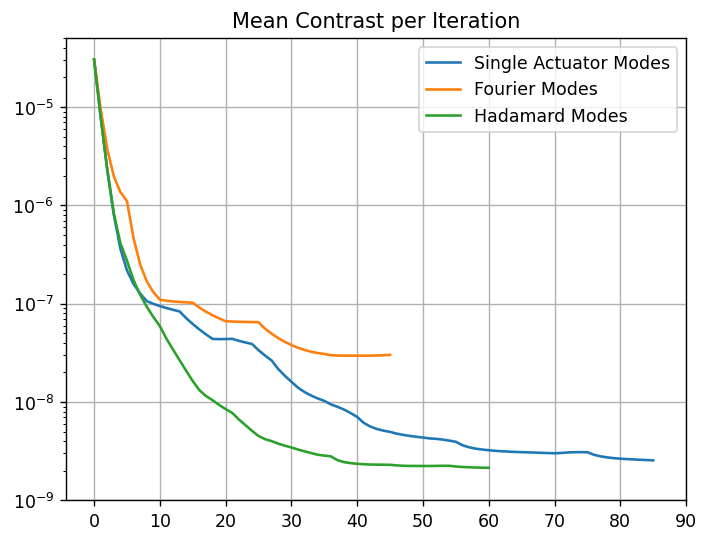

In [14]:
import matplotlib.pyplot as plt

plt.figure(dpi=125)

itrs = range(poke_contrast.shape[0])
plt.semilogy(itrs, poke_contrast, label='Single Actuator Modes')

itrs = range(fourier_contrast.shape[0])
plt.semilogy(itrs, fourier_contrast, label='Fourier Modes')


itrs = range(had_contrast.shape[0])
plt.semilogy(itrs, had_contrast, label='Hadamard Modes')

plt.ylim([1e-9, 5e-5])
plt.xticks(np.arange(0,100, 10))
plt.legend()
plt.title('Mean Contrast per Iteration')
plt.grid()

